
# Development of a RAG-LLM System by Elaine See




## Overview

This notebook showcases an ask-your-PDFs RAG solution built using open-sourced Large Multi-modal Model (LMM) & multi-vector retriever. This solution will:-
*   Answer questions based on information retrieved from PDF files (initial + newly uploaded files)
*   Provide referencing to PDF file names with page numbers will be provided alongside answer
*   Provide relevant visual aids (table/diagrams) from PDF will be provided
<br>
<br>

### **Frameworks Used**

| Component | Framework / Tool |
|----------|----------|
| PDF Document Parser | `unstructured` |
| Text Embedding | `nomic-embed-text-v1` |
| Multi-Vector Database & Retriever | `chromadb` (Multi-Vector) |
| LLM Framework | `langchain` |
| LLM/LMM Provider | `ollama` |
| Large Multi-modal Model | `llava-phi3` |

<br>

### **RAG Architecture Overview**

* Use LMM model ([`llama-phi3`](https://ollama.com/library/llava-phi3) to produce text summaries for both table & image summarization. Summaries will be embedded and use for retrieval.
* Use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) with [Chroma](https://www.trychroma.com/) to store text and non-text items (raw tables/images) along with their summaries for retrieval.
* Using text embedding, retrieve top k chunks based on text & summary, return corresponding text & raw table/image chunks.
* Pass text & raw tables/images chunks to a multimodal LLM for answer synthesis

![Model Architecture](https://raw.githubusercontent.com/ElaineSee/temporary-files/main/ModelArchitecture.png)

<br>

---  

### **Solution Outline**
Below are the steps that this solution will carry out:


1.   Change to GPU runtime.
2.   Upload `.env` file for Nomic API Key.
3.   Run cell to install dependencies.
4.   `[Special Action Required]` **Restart session as prompted** by popped-up window and **continue with Step 5**.
5.   `[Special Action Required]` Load `llava-phi3` using `ollama` using terminal open through `colab-xterm`
6.   Upload additional files on top of initial PDFs & choose to use pre-persisted Multi-vector DB or not.
7.   *Parse PDF & Extract Elements from Multiple PDF Documents.
8.   *Process Extracted Elements - Use LMM model to generate summaries for tables & figures, then concatenate with the table text content or figure captions.
9.   Build Multi-Vector Retriever by adding chunks from previous steps to the newly initiated/pre-persisted Multi-Vector DB.
10.  Set Up RAG Chain
11.  Sample Answers to Sample Queries. User can also launch UI for Q&A - Provide **answer**, **references to PDF file names & page numbers**, and **relevant images** retrieved from documents (if any).


*_These processing steps will be skipped if choose to Load Persisted MultiVectorDB at Step 6_
<br>
<br>

---
### **Initial PDF Files**

1.   12086054_03.pdf
2.   fb_reiser_et_al_sept_2021_gsx_qi.pdf

User can choose to upload additional files or not.
<br>
<br>

## **Instructions for Users**

**Step 1 - Ensure you have changed your runtime to "T4 GPU"**

**Step 2 - Ensure that you have uploaded the .env file to Colab** (or store it in the same local directory as this iPython Notebook). The Nomic API Key in the .env file is for free tier (up to 1M token embedding & 4000 image embeddings per month), in case it runs out of quota, kindly register an account at [Nomic's website](https://atlas.nomic.ai/) and replace the key with a newly generated one.

In [ ]:
# @title Step 3: Run this cell to install dependencies (takes 2-3mins)
%%capture captured_output
!sudo apt-get install poppler-utils
!pip install pytesseract
!sudo apt-get install tesseract-ocr
!pip install tesseract-ocr
!pip install langchain langchain-chroma langchain-ollama langchain-nomic
!pip install --upgrade gradio
!pip install "unstructured[pdf]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

In [ ]:
# @title Step 4: Run this cell, click "Restart Session" to reload updated packages, then proceed to Step 5
captured_output.show()

---
### Step 5: Run the following cell to load Ollama & pull Llava-Phi3-Mini model

1.  Run the cell below and wait for the terminal to appear.
2.  Then, copy and paste the command line below and run it in the terminal.

**`curl -fsSL https://ollama.com/install.sh | sh; ollama serve & ollama pull llava-phi3 & ollama run llava-phi3`**


It will take around 2-3mins to pull the model and get it running. You will see `success` at the end of the terminal when the model is successfully pulled & run.


<div>
<img src="https://raw.githubusercontent.com/ElaineSee/temporary-files/main/x-term-model-pulled.png" width="800"/>
</div>

**If the pull is not sucessful after 2-3mins, rerun this cell.**

Once the Llava-Phi3-Mini model is loaded, please proceed to the next step.

In [ ]:
# @title
!pip -q install colab-xterm
%load_ext colabxterm
%xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.8 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
# Try running this cell to see if model is pulled and can be used without issue
from langchain_ollama import ChatOllama
import httpx
model = ChatOllama(model="llava-phi3", temperature=0.1, num_predict=300)

try:
    print(model.invoke("Tell me a joke"))
except httpx.ConnectError:
    print("Model has not been pulled completely/successfully. Please redo previous step.")
except Exception as e:
    print(e)

del model

content="Why was the math book sad?\nBecause it had too many problems.\n\nI hope you found that joke amusing! Do you have any other questions or topics you'd like to discuss? I'm here to help with anything else you need." response_metadata={'model': 'llava-phi3', 'created_at': '2024-08-04T14:42:57.481714892Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1021640256, 'load_duration': 16521785, 'prompt_eval_count': 16, 'prompt_eval_duration': 43450000, 'eval_count': 56, 'eval_duration': 920242000} id='run-51937ee6-1acb-43ba-943e-b7a9f2d821df-0' usage_metadata={'input_tokens': 16, 'output_tokens': 56, 'total_tokens': 72}


---
### Step 6: Run the cell below to load pre-persisted multi-vector DB & upload additional PDF files

*   To save time, we load the pre-persisted MultiVectorDB from Github by default. It will load the docstore pickle file & ChromaDB that were previously persisted after processing the elements of the 2 default PDF files. **You may choose to unselect "Load_Persisted_MultiVectorDB" below, but it will take an extra 20-30minutes to extract, process & index the 2 default PDF files from scratch.**

*   After running the cell, celect **"Cancel Upload"** if you do not have additional file to upload & process. It will proceed with just the 2 default PDF files.

In [ ]:
# @title Load DB and/or Upload Additional Files {display-mode: "form"}

from google.colab import files
uploaded = files.upload()
pdf_paths = list(uploaded.keys())

Load_Persisted_MultiVectorDB = True # @param {type:"boolean"}
!wget https://github.com/ElaineSee/multimodal-rag/archive/refs/heads/main.zip -O multimodal-rag.zip
!unzip multimodal-rag.zip

# Load Persisted Multi-vector DB and skip the content extraction & processing
if Load_Persisted_MultiVectorDB:
    !mv multimodal-rag-main/multivector-db /content/multivectordb

# If don't use pre-persisted DB, upload 2 default PDF files for processing
else:
    !mv multimodal-rag-main/12086054_03.pdf /content/12086054_03.pdf
    !mv multimodal-rag-main/fb_reiser_et_al_sept_2021_gsx_qi.pdf /content/fb_reiser_et_al_sept_2021_gsx_qi.pdf
    pdf_paths = pdf_paths + ['12086054_03.pdf', 'fb_reiser_et_al_sept_2021_gsx_qi.pdf']

----
### **From here onwards, you could choose to "Run After" (CTRL+F10) to run all the cells after**

## Step 7: Parse PDFs to Extract Elements

### Partition PDF by elements
  
First, use `Unstructured` to partition the PDFs.


In [ ]:
%%time
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf
from typing import List, Dict, Any
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\USER\AppData\Local\Tesseract-OCR\tesseract.exe'

import os
os.environ['EXTRACT_IMAGE_BLOCK_CROP_VERTICAL_PAD'] = '50'

# Function to extract elements from PDF
def extract_pdf_elements(fname, imagepath_prefix):
    """
    Extract images, tables, and chunk text from a PDF file.
    fname: File name
    imagepath: Directory to store extract images (.jpg)
    """
    current_dir = os.getcwd()
    fpath = os.path.join(current_dir, fname)
    imagepath = os.path.join(current_dir, imagepath_prefix + fname)

    return partition_pdf(
        filename=fpath,
        extract_images_in_pdf=True, #False
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=2500,
        new_after_n_chars=1500,
        combine_text_under_n_chars=500, #1000, 2000
        extract_image_block_output_dir=imagepath,
    )


imgpath_prefix = 'extracted_imgs_'

# Run partition only if there is new PDF being uploaded
if pdf_paths:
    raw_pdf_elements_all = []
    for pdf in pdf_paths:
        # Get elements
        raw_pdf_elements_all.append(extract_pdf_elements(pdf, imgpath_prefix))

CPU times: user 5.61 s, sys: 937 ms, total: 6.55 s
Wall time: 15.3 s


---
## Step 8: Process Elements (Generate Summaries)

Next, we will remove overlapping/redundant images (some images extracted by Unstructured could be a sub-image of a bigger diagram).

Following that, we will generate text descriptions/summaries for the tables & images extracted from the PDF, which will be combined with the table text or the image caption in the retrieval process.

In [ ]:
# @title Load packages needed for this step
from shapely.geometry import Polygon
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
import base64

summary_model = ChatOllama(model="llava-phi3", temperature=0.1, num_predict=300)

In [ ]:
# @title Functions to find main images and remove overlapping images

def get_all_nonoverlap_images(raw_pdf_elements):
    """Keep main images and remove overlapping images extracted from PDF"""

    ## Helper functions to remove overlapping images
    # Get the polygon area from coordinates extracted from PDF
    def get_img_polygons(raw_pdf_elements, page_num, img_start_num):
        j = img_start_num
        polygons = {}
        for element in raw_pdf_elements:
            if "unstructured.documents.elements.CompositeElement" in str(type(element)):
                for e in element.metadata.orig_elements:
                    if "unstructured.documents.elements.Image" in str(type(e)) and \
                    e.metadata.page_number == page_num:
                        coords = e.metadata.coordinates.points
                        figname = f"figure-{e.metadata.page_number}-{j}.jpg"
                        polygons[figname] = (Polygon(coords))
                        j += 1
        return polygons

    # For each page, get all the polygons within it
    def get_main_images(raw_pdf_elements):
        last_pg_num = raw_pdf_elements[-1].metadata.orig_elements[-1].metadata.page_number
        all_polygons = {}
        img_start_num = 1
        for i in range(last_pg_num + 1):
            p = get_img_polygons(raw_pdf_elements, i, img_start_num)
            all_polygons[i] = p
            img_start_num += len(p)
        return all_polygons

    # Given a list of polygons, return a list of non-overlapping polygons with the max total area.
    def find_nonoverlap_polygons(polygons_dict):
        polygons_sorted = sorted(polygons_dict.items(), key=lambda item: item[1].area, reverse=True)
        selected_polygons = []
        selected_pkeys = []
        for key, polygon in polygons_sorted:
            if all(not polygon.intersects(p) for p in selected_polygons):
                selected_polygons.append(polygon)
                selected_pkeys.append(key)
        return selected_pkeys

    polygons_all_dict = get_main_images(raw_pdf_elements)
    final_img_list = []
    for d in polygons_all_dict.values():
        img_list = find_nonoverlap_polygons(d)
        final_img_list += img_list
    return final_img_list


def delete_jpgs(dir, files_to_keep):
    """Delete images that are not shortlisted"""
    # Get a list of all .jpg files in the directory
    all_files = [f for f in os.listdir(dir) if f.endswith('.jpg')]
    set_to_keep = set(files_to_keep)

    # Check if all shortlisted non-overlapping images is in the directory
    if not all(img in all_files for img in files_to_keep):
        files_to_keep = list(all_files)
        print(
            'Some shortlisted image paths after checking image overlappings are not found in the image directory.\n'
            'We will process all extracted images, including overlapping ones.'
        )
    else:
        # Delete those not in list to keep
        for file in all_files:
            if file not in set_to_keep:
                file_path = os.path.join(dir, file)
                os.remove(file_path)
                print(f"Deleted overlapped image: {file_path}")

In [ ]:
# @title Functions to generate summaries/descriptions for tables & images

def table_summarize(table_element, model=summary_model):
    """Make table summary"""
    prompt = """You are an assistant tasked with describing or summarizing tables for retrieval. \
    These descriptions will be embedded and used to retrieve the raw table elements. \
    Give a concise text description in 3-4 sentences for this table: {element} """
    input_prompt = ChatPromptTemplate.from_template(prompt)
    summarize_chain = {"element": lambda x: x} | input_prompt | model | StrOutputParser()
    return summarize_chain.invoke(table_element)


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, model=summary_model):
    """Make image summary"""

    prompt = """You are an assistant tasked with describing or summarizing figures for retrieval. \
    These descriptions will be embedded and used to retrieve the image or figure. \
    Give a concise text description in 2-4 sentences for the figure."""

    def prompt_func(data):
        text = data["text"]
        image = data["image"]
        image_part = {
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{image}",
        }
        content_parts = []
        text_part = {"type": "text", "text": text}
        content_parts.append(image_part)
        content_parts.append(text_part)
        return [HumanMessage(content=content_parts)]

    chain = prompt_func | model | StrOutputParser()
    return chain.invoke({"text": prompt, "image": img_base64})

In [ ]:
# @title Function to process elements
def processing_elements(raw_pdf_elements_all):
    """
    Categorize extracted elements from a PDF into tables and texts
    & generate summarises for non-text elements.

    raw_pdf_elements_all: List of List of unstructured.documents.elements
    """
    tables_with_pg = []
    texts_with_pg = []
    ocr_images_with_pg = []
    imgdir_prefix = os.path.join(os.getcwd(), imgpath_prefix)

    for raw_pdf_elements in raw_pdf_elements_all:
        # Remove overlapping images
        shortlisted_imgs = get_all_nonoverlap_images(raw_pdf_elements)
        img_dir_ = imgdir_prefix + raw_pdf_elements[0].metadata.filename
        delete_jpgs(img_dir_, shortlisted_imgs)
        next_is_caption = False

        for element in raw_pdf_elements:
            # Process table elements
            if "unstructured.documents.elements.Table" in str(type(element)):
                html_table = element.metadata.text_as_html
                table_summary = table_summarize(html_table)
                table = {'text': str(element) + '\n' + table_summary,
                        'html_table': html_table,
                        'filename': element.metadata.filename,
                        'page_number': element.metadata.page_number}
                tables_with_pg.append(table)

            # Process composite (non-table) elements
            elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
                composite_text = ''

                for e in element.metadata.orig_elements:
                    # Process image element
                    if "unstructured.documents.elements.Image" in str(type(e)):
                        if os.path.basename(e.metadata.image_path) in shortlisted_imgs:
                            base64_image = encode_image(e.metadata.image_path)
                            image_summary = image_summarize(base64_image)
                            ocr_image = {'text': e.text,
                                        'image_path': e.metadata.image_path,
                                        'filename': element.metadata.filename,
                                        'page_number': e.metadata.page_number,
                                        'description': image_summary,
                                        'base64': base64_image}
                            ocr_images_with_pg.append(ocr_image)

                            # Assume that the text chunk after image is caption/description
                            next_is_caption = True

                    # Get caption & concatenate with summary of previous image
                    elif next_is_caption and \
                    any(word in str(type(e))for word in ['FigureCaption', 'NarrativeText']):
                        caption = e.text
                        ocr_images_with_pg[-1]['description'] = \
                            caption + '\n' + ocr_images_with_pg[-1]['description']
                        next_is_caption = False

                    # Remaining elements will be treated as text element
                    # Concatenate the texts into one chunk
                    else:
                        composite_text += e.text if composite_text =='' else '\n\n' + e.text

                text = {'text': composite_text,
                        'filename': element.metadata.filename,
                        'page_number': element.metadata.page_number}
                texts_with_pg.append(text)

    return texts_with_pg, tables_with_pg, ocr_images_with_pg

Process the all of the raw PDF elements extracted in the previous step:

In [ ]:
%%time
if pdf_paths:
    text_chunks, table_chunks, image_chunks = \
        processing_elements(raw_pdf_elements_all)
    print(f"Number of text chunks processed: {len(text_chunks)}")
    print(f"Number of table chunks processed: {len(table_chunks)}")
    print(f"Number of image chunks processed: {len(image_chunks)}")
else:
    print(f"No new PDF files to be processed.")
    text_chunks, table_chunks, image_chunks = [], [], []

No new PDF files to be processed.
CPU times: user 1.48 ms, sys: 0 ns, total: 1.48 ms
Wall time: 1.41 ms


----
## Step 9: Build Multi-vector Retriever & Add Documents (if any)

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) to index image and table summaries, but retrieve raw images alongside the summaries/texts.

Use a LMM (here we use Llava-Phi3-Mini) to produce table and image summaries/descriptions. Summaries are used to retrieve raw diagrams.

### Add to vectorstore
Firstly, we create a vectorstore.

Then, we will add raw documents (text/tables/images) and their text info respectively:

* Store the texts, raw tables, and images in the `docstore`.
* Store the texts, table summaries, and image summaries in the `vectorstore` for efficient semantic retrieval.

For this solution, we use Nomic Embedding `nomic-embed-text-v1`.

Lastly, we will create a multi-vector retriever using both the `vectorstore`and `docstore`.

In [ ]:
# @title Load packages needed for this step
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_nomic.embeddings import NomicEmbeddings
from IPython.display import HTML, display, Image
import io
from io import BytesIO
import numpy as np
from PIL import Image as PILImage
from dotenv import load_dotenv
import pickle
import chromadb

load_dotenv()
try:
    os.environ["NOMIC_API_KEY"] = os.getenv('NOMIC_API_KEY')
except TypeError as e:
    print("Did you forget to upload the .env file?")
    raise e

embedding_function = NomicEmbeddings(model="nomic-embed-text-v1")

In [ ]:
# @title Helper Functions to Load Persisted Multi-VectorDB & Create Multi-Vector Retriever

def load_inmemory_docstore(pickle_path='in_memory_store.pkl'):
    """Load the store from pickle file from local"""
    with open(pickle_path, 'rb') as f:
        in_memory_store = pickle.load(f)
    return in_memory_store


def load_chroma_vectordb(embedding_function=embedding_function,
                         collection_name='mmrag',
                         chromadb_path="/content/chromadb"):
    """Load the Chroma vectorstore from local"""
    return Chroma(
        client=chromadb.PersistentClient(path=chromadb_path),
        collection_name='mmrag',
        embedding_function=embedding_function
        )


def create_multi_vector_retriever(
    vectorstore, docstore, text_chunks, table_chunks, image_chunks
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    id_key = "doc_id"

    # Create the multi-vector retriever using base vectorstore & docstore
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key=id_key,
    )

    def add_documents(retriever, doc_chunks, text_col, item_col):
        """Add documents to the base vectorstore and docstore in retriever"""
        doc_ids = [str(uuid.uuid4()) for _ in doc_chunks]
        text_docs = [
            Document(page_content=doc[text_col],
                     metadata={id_key: doc_ids[i],
                               'page_number': doc['page_number'],
                               'filename': doc['filename']})
            for i, doc in enumerate(doc_chunks)
        ]
        item_docs = [d[item_col] for d in doc_chunks]
        retriever.vectorstore.add_documents(text_docs)
        retriever.docstore.mset(list(zip(doc_ids, item_docs)))

    # Add texts, tables, and images data respectively
    # Check that text_chunks is not empty before adding
    if text_chunks:
        add_documents(retriever, text_chunks, 'text', 'text')
    # Check that table_chunks is not empty before adding
    if table_chunks:
        add_documents(retriever, table_chunks, 'text', 'html_table')
    # Check that image_chunks is not empty before adding
    if image_chunks:
        add_documents(retriever, image_chunks, 'description', 'base64')

    return retriever

Initiate VectorDB & Document Store as part of Retriever, then add newly processed elements to it.

In [ ]:
# If chose to load pre-persisted Multi-Vector DB, then use them as base db
if Load_Persisted_MultiVectorDB:
    docstore = load_inmemory_docstore('/content/multivectordb/in_memory_store.pkl')
    vectordb = load_chroma_vectordb(
        embedding_function=embedding_function,
        collection_name='mmrag',
        chromadb_path="/content/multivectordb/chromadb"
        )

# Else, initiate InMemoryStore & new ChromaDB
else:
    docstore = InMemoryStore()
    vectordb = Chroma(
        collection_name="mmrag",
        embedding_function=embedding_function,
        persist_directory='/content/chromadb',
    )

# Create retriever using the docstore & vectorstore and add documents to it
multivector_retriever = create_multi_vector_retriever(
    vectordb, docstore, text_chunks, table_chunks, image_chunks
)

----
## Step 10: Set up RAG Chain

In [ ]:
# @title Functions & Configurations for RAG Chain
import re
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
import httpx
import gradio as gr

def plt_img_base64(img_base64):
    """Display base64 encoded string as image"""
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = PILImage.open(io.BytesIO(img_data))

    # Resize the image & save the resized image to a bytes buffer
    resized_img = img.resize(size, PILImage.LANCZOS)
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """Split base64-encoded images and texts"""
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """Join the context into a single string"""
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": f"data:image/jpeg;base64,{image}",
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an assistant tasked with answering questions based on information derived from scientific articles or documents.\n"
            "You will be given a mixed of text, tables, and image(s) usually of figures derived from the document in the Context section.\n"
            "Context:\n"
            f"{formatted_texts}\n####################\n"
            "Use the information in the Context to respond to the User question below."
            f"User question: {data_dict['question']}\n\n"
            "Be honest if you do not know the answer. \n"
            # "Reply 'This is not a question.' if the user question is not a question. \n"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""
    model = ChatOllama(model="llava-phi3", temperature=0.3, num_predict=512)
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )
    return chain


def to_PILImage_tuple_list(image_base64_list):
    """Convert list of Base64 strings to list of PIL Images"""
    img_tuple_list = []
    for img_base64 in image_base64_list:
        img_data = base64.b64decode(img_base64)
        img_tuple = (PILImage.open(io.BytesIO(img_data)), None)
        img_tuple_list.append(img_tuple)
    return img_tuple_list


# Invoke query and format final output answer
def answer_gradio(question):
    """Function to generate answer outputs to feed to Gradio"""

    # Get the text information
    text_docs = multivector_retriever.vectorstore.similarity_search(question)

    # Get file names & page numbers as references
    source_list = set(
        [f"Page {d.metadata.get('page_number')} of {d.metadata.get('filename')}"
         for d in text_docs]
        )
    ref_source = 'References:-\n    ' + '\n    '.join(source_list)

    # Get response from RAG LLM
    try:
        result = chain_multimodal_rag.invoke(question)
    except httpx.ConnectError:
        raise gr.Error("Model connection error. Is the Llava-Phi3 model running?",
                       duration=20)
    except Exception as e:
        raise gr.Error(e, duration=20)


    # Get related/retrieved image(s)
    item_docs = multivector_retriever.invoke(question)
    image_base64_list = [i for i in item_docs if is_image_data(i)]

    # Format results into outputs
    if image_base64_list:
        answer_with_ref = f"{result}\n\n{ref_source}"
        images = to_PILImage_tuple_list(image_base64_list)
    else:
        answer_with_ref = f"{result}\n\n{ref_source}"
        images = []

    return answer_with_ref, images

---
## Step 11: Sample Answers using RAG chain & Launch Gradio Q&A Interface

This section showcases the final solution. After setting up the RAG chain & sample queries, it shows the sample answers to the sample queries. You may launch the Gradio Interface using the "Launch Gradio UI" cell in the end of this section.

In [ ]:
# Create RAG chain
multivector_retriever.search_kwargs['k'] = 3
chain_multimodal_rag = multi_modal_rag_chain(multivector_retriever)

# Some sample questions to answer
queries = [
        "The shallow ground of Yerevan city is composed by what?",
        "Which parts of Yerevan city is the Type 3 surface distributed?",
        "Is there any sizable near-field exploration targets or opportunities around Lille Prinsen?",
        "What is the main geological challenges present in the multi-azimuth multisensor survey area in the prolific South Viking Graben",
        "The MAZ multisensor acquisition solution was designed to overcome what challenges?",
        'Please provide me the images related to "Altitude of the upper end of Vs velocity layer"',
        "How are the damages of underground gas pipes being calculated? What are the coefficient of material and diameter being used in the formula?",
              ]


##################### Question 1 #####################

Question: The shallow ground of Yerevan city is composed by what?
Answer: The shallow ground of Yerevan city is composed by volcanic rocks, sedimentary rocks and terrace deposits. The surface layer is composed by cracked volcanic rock (basalt) in north area, by weathered sedimentary rock in south east area and by terrace deposits in south and west area.

Reference:
  Page 18 of 12086054_03.pdf
  Page 31 of 12086054_03.pdf
  Page 1 of 12086054_03.pdf

##################### Question 2 #####################

Question: Which parts of Yerevan city is the Type 3 surface distributed?
Answer: 
Based on the information provided in the context, Type 3 surface is distributed in the south and south-east part of Yerevan city.

Relevant Figure(s): 



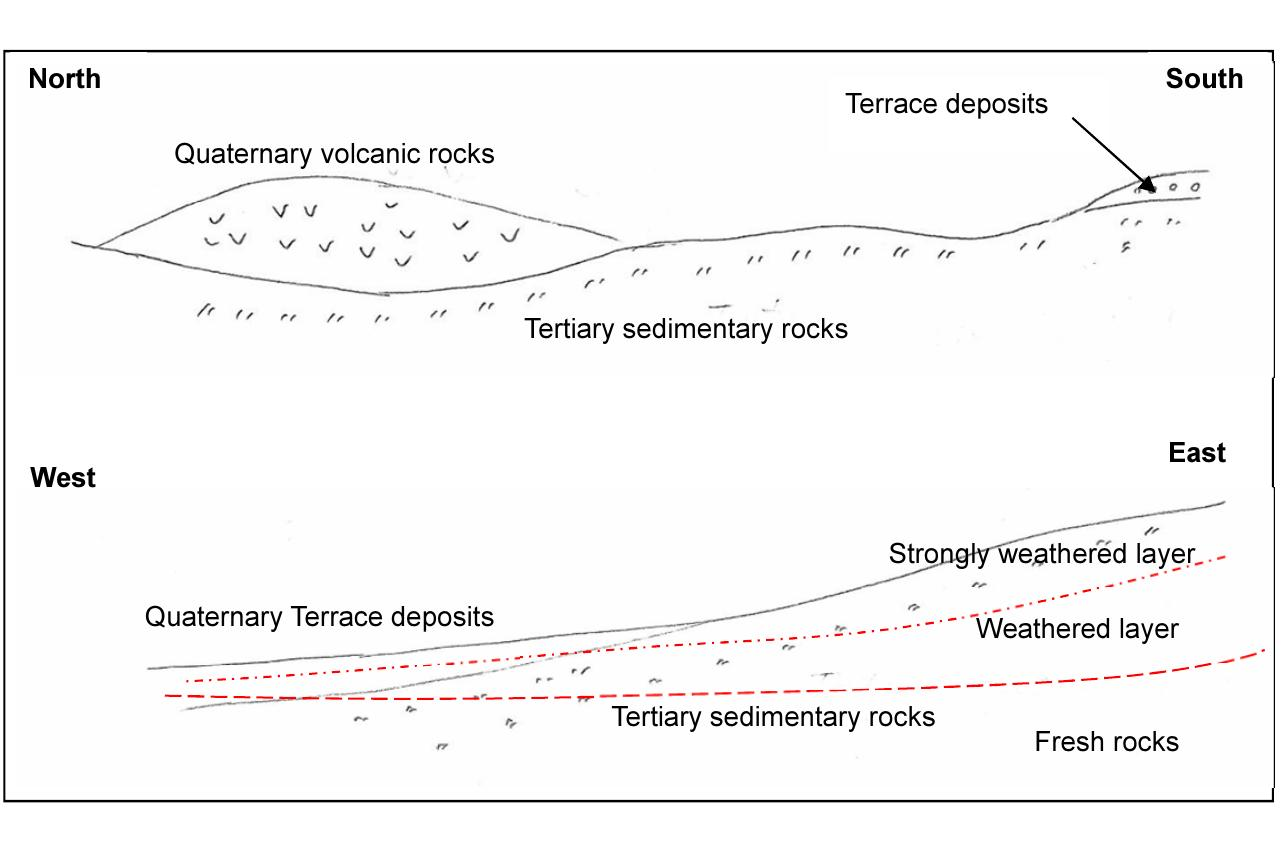

Reference:
  Page 5 of 12086054_03.pdf
  Page 6 of 12086054_03.pdf
  Page 1 of 12086054_03.pdf

##################### Question 3 #####################

Question: Is there any sizable near-field exploration targets or opportunities around Lille Prinsen?
Answer: 
Based on the information provided in the context, there are several sizable near-field exploration targets or opportunities around Lille Prinsen. The multi-azimuth quantitative interpretation of the pre-Cretaceous interval (Figure 7) revealed clear indications of hydrocarbons at the Upper Jurassic and Zechstein levels, which could constitute interesting near-field exploration targets. Additionally, recent discoveries include Lille Prinsen, drilled in 2018, which encountered various hydrocarbon intervals in the Eocene (Grid sand), Paleocene (Heimdal sand) and Permian (Zechstein Group).

Relevant Figure(s): 



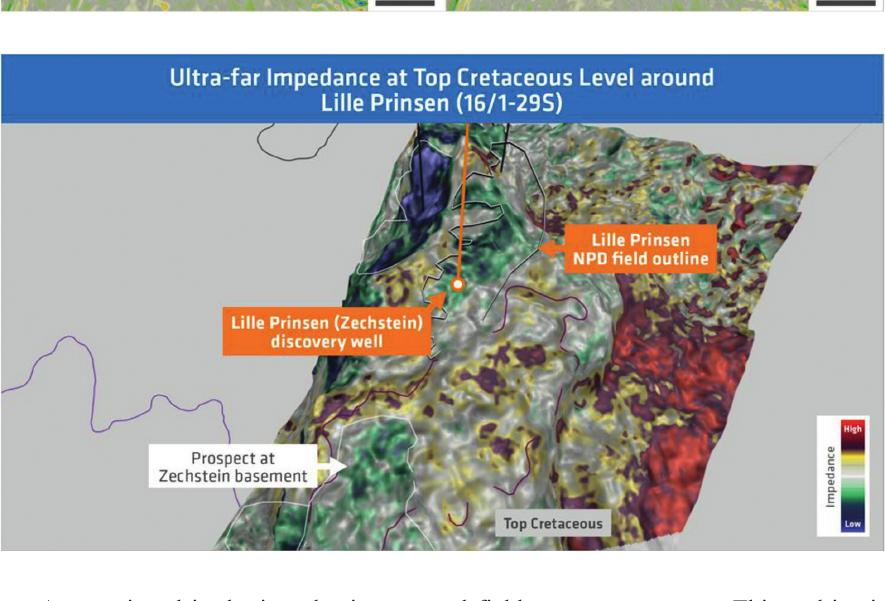

Reference:
  Page 2 of fb_reiser_et_al_sept_2021_gsx_qi.pdf
  Page 5 of fb_reiser_et_al_sept_2021_gsx_qi.pdf

##################### Question 4 #####################

Question: What is the main geological challenges present in the multi-azimuth multisensor survey area in the prolific South Viking Graben
Answer: The main geological challenges present in the multi-azimuth multisensor survey area in the prolific South Viking Graben are related to complex geological features such as injectites and fluvial channels, which provide limited illumination when using narrow-azimuth seismic acquisition. This can limit the reliability of full reservoir characterization in terms of azimuthal anisotropy estimation. Therefore, it is important to use a more comprehensive approach such as multi-azimuth broadband seismic with wide-tow triple-source shooting, which has been used in this study to overcome the main exploration challenges and improve understanding and characterization of various reservoir int

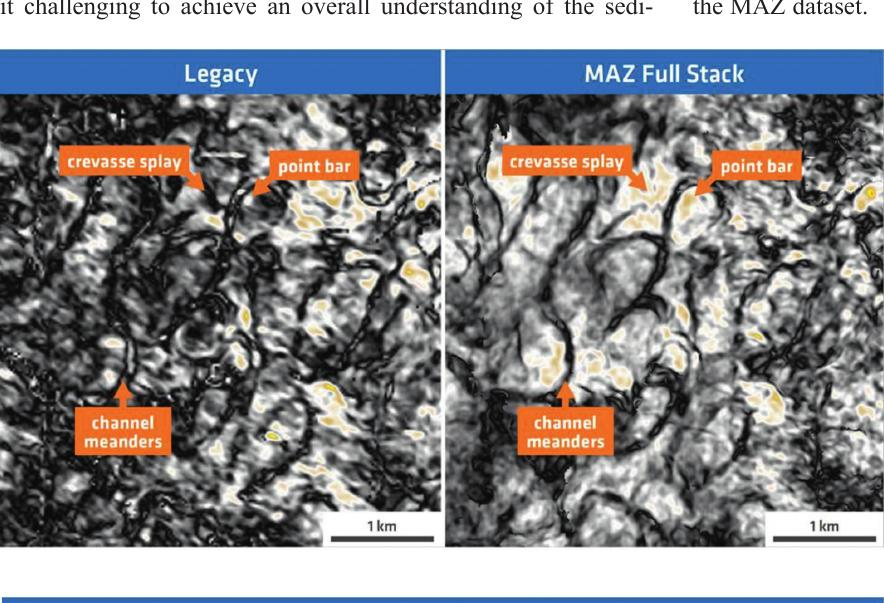

Reference:
  Page 2 of fb_reiser_et_al_sept_2021_gsx_qi.pdf
  Page 4 of fb_reiser_et_al_sept_2021_gsx_qi.pdf
  Page 5 of fb_reiser_et_al_sept_2021_gsx_qi.pdf

##################### Question 6 #####################

Question: Please provide me the images related to "Altitude of the upper end of Vs velocity layer"
Answer: 
Figure A-3: Altitude of the upper end of Vs velocity layer.

Relevant Figure(s): 



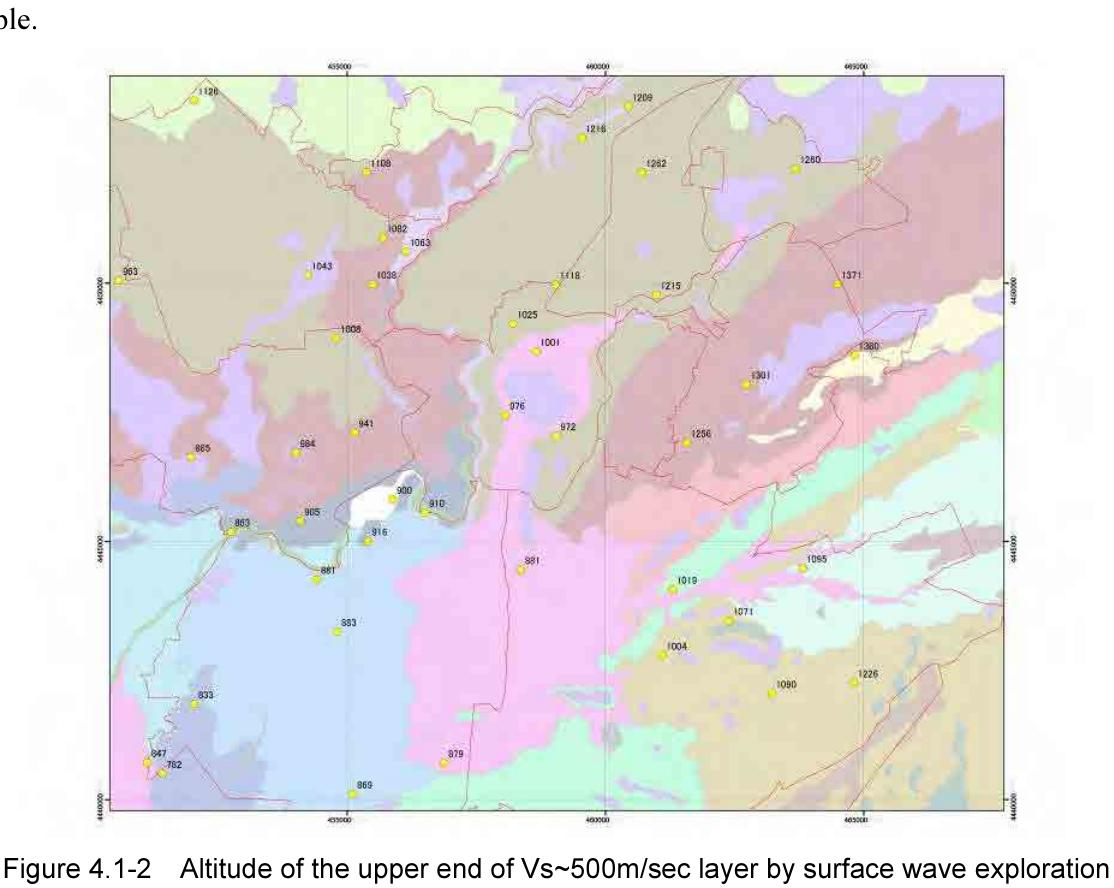

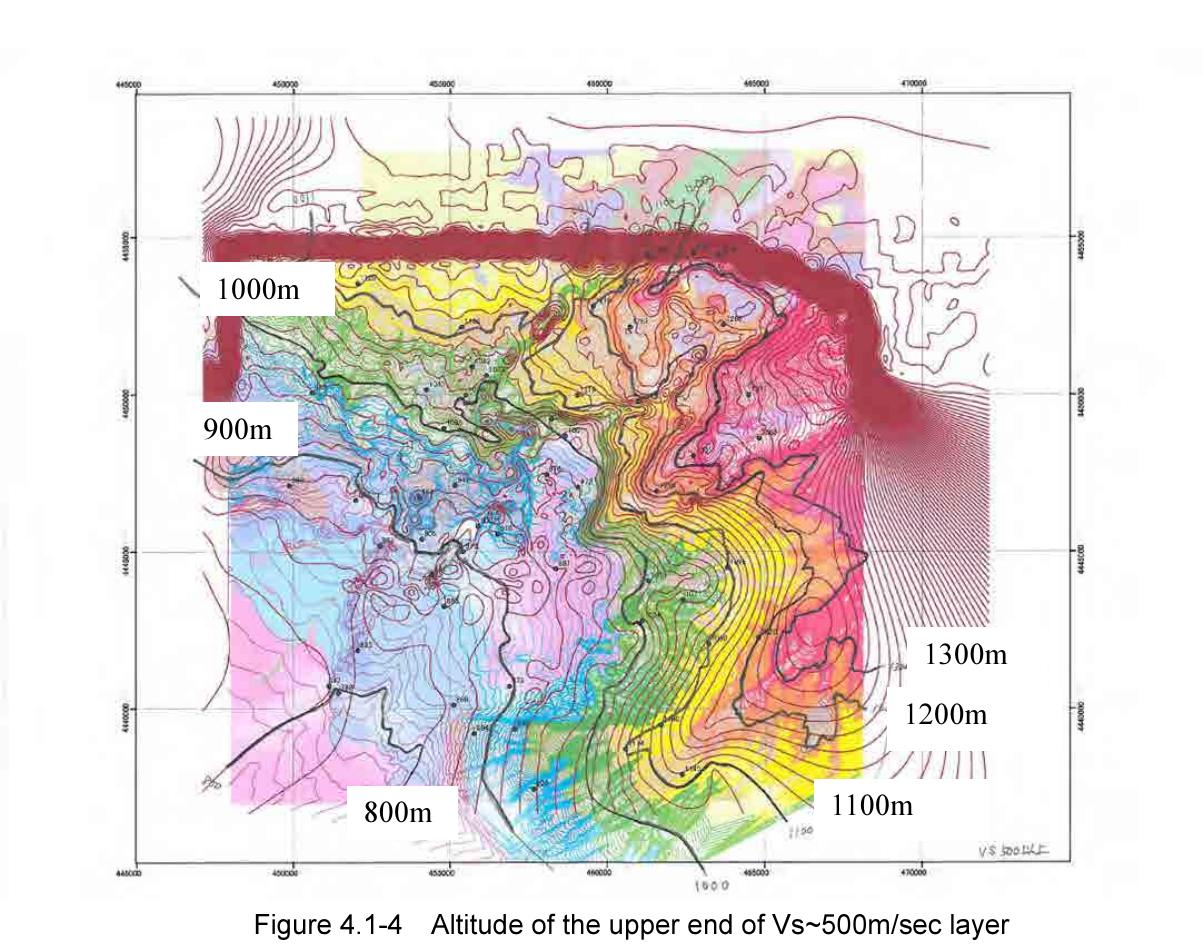

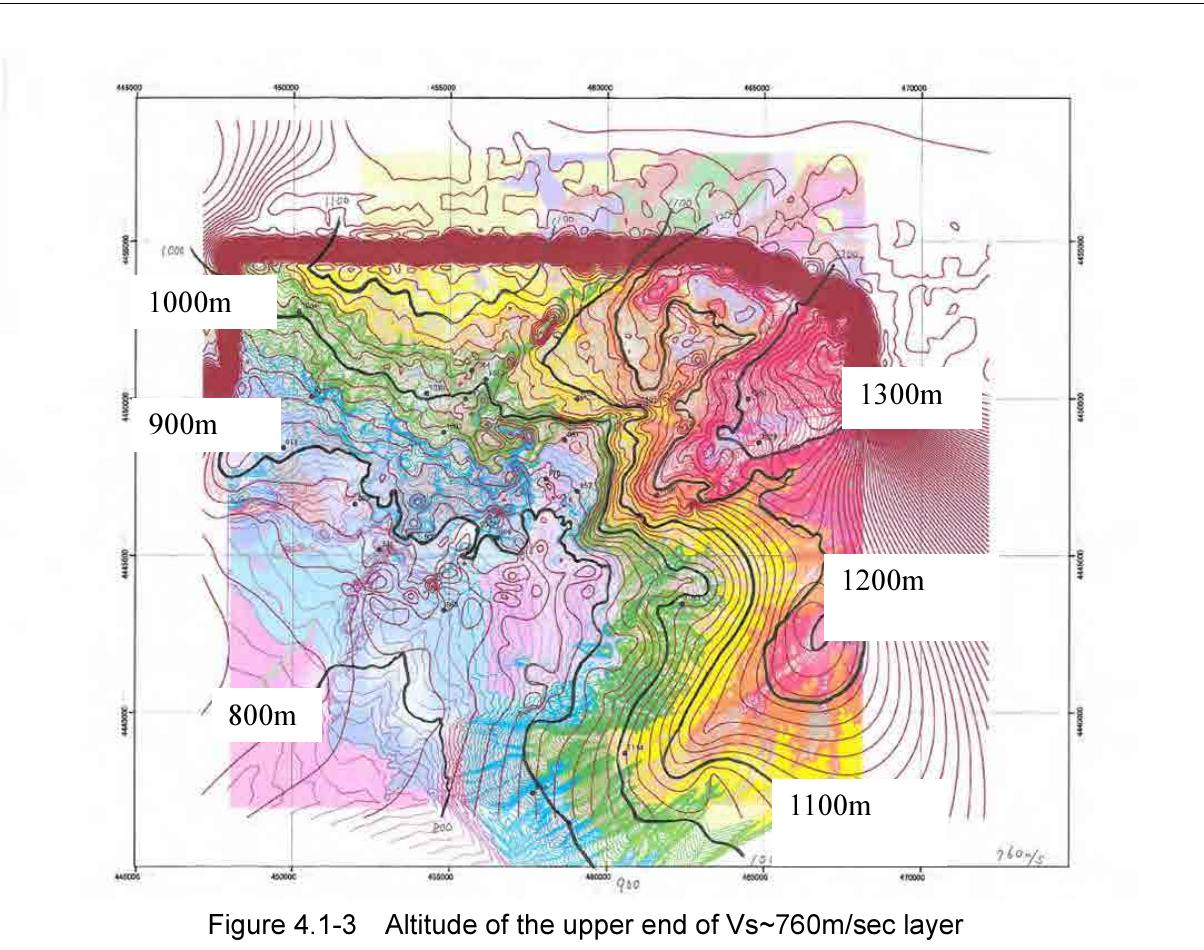

Reference:
  Page 2 of fb_reiser_et_al_sept_2021_gsx_qi.pdf
  Page 3 of 12086054_03.pdf
  Page 2 of 12086054_03.pdf

##################### Question 7 #####################

Question: How are the damages of underground gas pipes being calculated? What are the coefficient of material and diameter being used in the formula?
Answer: 
The damages of underground gas pipes are being calculated using the damage function formula: Rm = R · Cp · CD · Cl, where Rm is the damage function (point/km), R is the damage rate (point/km), Cp is the pipe material coefficient, CD is the pipe diameter coefficient, and Cl is the liquefaction coefficient.

The coefficients of material and diameter are being used in the formula from Table 5.7-6:

Cp : Pipe material coefficient (see Table 5.7-6)
CD : Pipe diameter coefficient (see Table 5.7-6)

Relevant Figure(s): 



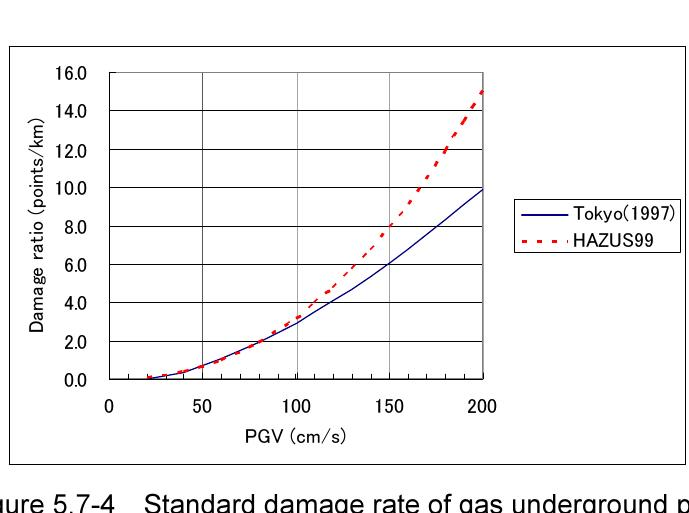

Reference:
  Page 71 of 12086054_03.pdf
  Page 74 of 12086054_03.pdf
  Page 73 of 12086054_03.pdf


In [ ]:
# @title Generate sample answers to sample queries

def display_images(image_base64_list):
    """Display image as HTML image"""
    images_to_display = []
    for image_b64 in image_base64_list:
        image = display(Image(base64.b64decode(image_b64)))
        images_to_display.append(image)
    return images_to_display


def answer(question, rag_qa_chain, retriever):
    """Answer and format answer to display in iPython Notebook"""
    text_docs = retriever.vectorstore.similarity_search(question)

    # Get page numbers of references
    source_list = set(
        [f"Page {d.metadata.get('page_number')} of {d.metadata.get('filename')}"
         for d in text_docs]
        )
    ref_source = 'Reference:\n  ' + '\n  '.join(source_list)

    # Render relevant image(s)
    item_docs = retriever.invoke(question)
    image_base64_list = [i for i in item_docs if is_image_data(i)]

    # Get response from RAG LLM
    result = rag_qa_chain.invoke(question)

    # Format as final output
    if image_base64_list:
        print(f"Answer: {result}\n")
        print(f"Relevant Figure(s): \n")
        display_images(image_base64_list)
        print(ref_source)
    else:
        print(f"Answer: {result}\n")
        print(ref_source)

# Return answers to sample queries
for i, query in enumerate(queries):
    print(f"\n##################### Question {i+1} #####################\n")
    print(f"Question: {query}")
    answer(query, chain_multimodal_rag , multivector_retriever)

<br>
<br>

---

In [ ]:
# @title Launch Gradio UI

# Set up Gradio Interface
gradio_ui = gr.Interface(
    fn = answer_gradio,
    inputs = gr.Textbox(label="Question", lines=5),
    outputs = [gr.Textbox(label="Answer"), gr.Gallery(label="Related Images")],
    examples = queries,
    # cache_examples = True,
    allow_flagging = "never"
             )

# Launch Gradio UI
gradio_ui.launch(height=700)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://de0b90ec614d8762e6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


---
## Other Considerations


* The configurations (chunking size, prompt, model temperature etc) used in this solution are adjusted based on the nature & domain of 2 initial PDFs.

* To accommodate for PDFs with different nature e.g. tables with a lot of rows within PDFs, it would need **adjustments to the processing pipeline, parameters & configuration** (e.g. do not combine table summaries with the table text info as it might exceed the average chunking size, or use embedding that can handle larger context length)

* Besides, image retrieval can fail to competing text chunks if text chunks are broken down into small (and many). Mightneed extra steps (e.g. create summary for text chunks too) to mitigate.



## References





*   https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb
*   https://medium.com/@mauryaanoop3/running-ollama-on-google-colab-free-tier-a-step-by-step-guide-9ef74b1f8f7a
*   https://www.google.com/url?q=https%3A%2F%2Fmedium.com%2F%40ranjithkumar.panjabikesanind%2Fchat-with-your-multiple-documents-build-a-multi-document-q-a-conversational-bot-leveraging-cb244098eb2d
*   https://www.google.com/url?q=https%3A%2F%2Fwww.gradio.app%2Fguides%2Fcreating-a-chatbot-fast



### **Thanks for taking the time to go through my solution! All feedbacks are welcomed!**